We discussed the multi-armed bandit problem in class today.  This is the starting point for <b>reinforcement learning</b>, or learning how to behave in some <b>environment</b> over time.

In the basic version of the multi-armed bandit problem problem, we have $N$ slot machines, each with a different *fixed* probability distribution of the amount of payout they have each time we "pull" on them.  We don't know how they behave going in, and our job is to maximize the payout over some number of pulls of the bandits.  In particular, we need to come up with a <b>policy</b> (a set of actions to take over time) that maximizes the <b>reward</b> (in this case, the cumulative sum of all amounts of money we get at each pull).  The trick is, since we don't know anything about the bandits, we have to learn and update our policy over time as we explore and get more information.

First, let's define what a bandit is in code, and then we'll talk more about how to learn different policies for this problem.

We're going to use a class called "Bandit" to encapsulate what it means to be a bandit.  For the probability distributions, we'll pick numbers uniformly at random between 0 and some maximum value for each bandit.  The maximum value is the hidden parameter.  We'll "seed" the maximum value so that it seems to be randomly different for each bandit, but so that we all get the same results each time we run it.  This is known as <a href = "https://ursinus-cs174-s2022.github.io/CoursePage/ClassExercises/Week4_Binary_LFSR/#bglfsr">pseudorandomness</a>.  Let's see how we'd define such a class below:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
class Bandit:
    def __init__(self, seed):
        """
        The constructor for bandit objects
        
        Parameters
        ----------
        seed: int
            A seed for the pseudorandom number generator.  Different seeds
            will give different values of the max this bandit can give at
            any pull (self.mx)
        """
        
        self.seed = seed
        np.random.seed(seed)
        self.mx = np.random.rand()*10
    
    def pull(self):
        """
        Returns
        -------
        One random pull of this bandit, which returns a number in [0, self.mx]
        """
        return np.random.rand()*self.mx
    
    def __repr__(self):
        return "Bandit seed {}, Max Payout {:.3f}".format(self.seed, self.mx)
    
# Setup a list of 4 bandits and print them out
bandits = [Bandit(i*2) for i in range(4)]
for b in bandits:
    print(b)
results = {}

Bandit seed 0, Max Payout 5.488
Bandit seed 2, Max Payout 4.360
Bandit seed 4, Max Payout 9.670
Bandit seed 6, Max Payout 8.929


In the above list of 4 bandits, we see the one at index 2 has the maximum payout.  So ideally, our policy would be to just pull on that one over and over.  But we don't necessarily know that information going in, so we're going to have to learn it *online* as we're pulling on the bandits.  

Below I'll discuss several strategies for automating good policy discovery.  In each case, the algorithm will trade off <b>exploration</b> vs <b>exploitation</b>.  The more the algorithm tries out the different bandit arms, the more it learns about each one, but the less time it has to exploit (pull on) the one that seems to be doing the best.  By contrast, we can explore very little (e.g. some people in class only pulled on each bandit once at the beginning and then went with the one that paid the most that one time).  But we might then not have correct information about which bandit is the best.

## Epsilon-Greedy Strategy

Our first strategy is known as an $\epsilon$-greedy strategy.  The idea is that an $\epsilon$ proportion of the time, we will explore by randomly choosing a bandit to pull on, and the rest of the time we will pull on the one that has the greatest <i>average</i> payout so far.

Our strategy for figuring out when to explore is akin to throwing a dart uniformly at random into the unit interval $[0, 1]$ at each pull.  If the dart is in the interval $[0, \epsilon]$, then we will choose to pull a bandit at random.  Otherwise, we will pull on the one that has the highest average payout so far.  The picture below depicts this, where the red dots choose to randomly explore and the blue dots when it chooses to pull the one it thinks is the best so far:

<img src = "EpsDarts.svg" width="50%">

Let's write some code to execute this strategy on some list of bandits for some number of pulls, and we'll test it out for $\epsilon = 0.1$, or exploring 10% of the time and exploiting 90% of the time

4469.00726124155


Text(0, 0.5, 'Bandit index')

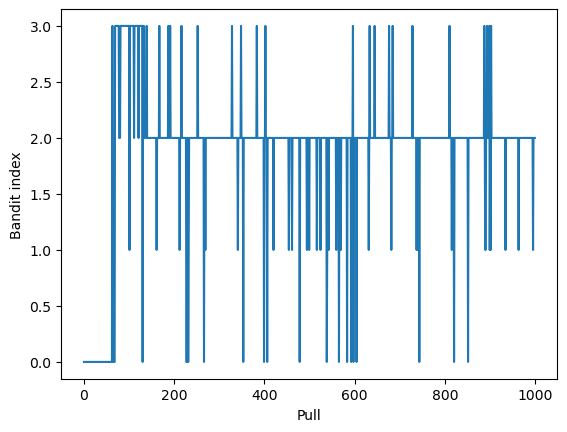

In [5]:
def epsilon_greedy(bandits, total_pulls, eps):
    """
    Parameters
    ----------
    bandits: list of Bandit
        The bandits that we can pull on
    total_pulls: int
        Number of pulls to execute
    eps: float in [0, 1]
        Every eps proportion of pulls, on average, I choose a random one to pull.  
        Otherwise, I pull the one that has the greatest *average* payout
        Ex) eps = 0.1, I'll explore 10% of the time, exploit the 
        one I think is the best 90% of the time
    
    Returns
    -------
    total_reward: float
        The total reward we got after all pulls
    choices: ndarray(total_pulls, dtype=int)
        The index of the bandit chosen at each pull over time
    """
    n_bandits = len(bandits)
    total_reward = 0
    pulls   = np.zeros(n_bandits)   # Create an array of all 0's which stores how many pulls are taken at each bandit
    payouts = np.zeros(n_bandits)   # Create an array of all 0's which stores the payout of each bandit so far
    choices = np.zeros(total_pulls) # Create an array of all 0's stores the index of the bandit chosen at each pull
    for pull in range(total_pulls):
        ## Step 1: Choose which bandit to pull
        dart = np.random.rand() # Choose number in [0, 1]
        if dart <= eps:
            # If this number is in [0, eps], choose a random bandit
            idx = np.random.randint(n_bandits)
        else:
            # Otherwise, choose bandit which has maximum avg payout so far
            denom = np.array(pulls)
            denom[denom == 0] = 1 # Avoid divide by 0
            avgs = payouts / denom
            idx = np.argmax(avgs) #
        
        ## Step 2: Pull the bandit that we intend to pull, increment the number of pulls
        ## for that bandit, and accumulate the reward for that bandit and for our total
        reward = bandits[idx].pull()
        total_reward += reward
        pulls[idx] += 1
        payouts[idx] += reward
        choices[pull] = idx
    
    return total_reward, choices


total_reward, choices = epsilon_greedy(bandits, total_pulls=1000, eps=0.1)
print(total_reward)
plt.plot(choices)
plt.xlabel("Pull")
plt.ylabel("Bandit index")

We see here that we got a pretty decent payout, but if you run this cell multiple times, you'll see different results.  What we should really do is setup an experiment where we repeat this many times for different numbers pulls for different $\epsilon$ values, and then take the average for each $\epsilon$ for each number of pulls to get an idea of the overall behavior.  Let's explore this below.  We'll setup a dictionary to keep track of the results, where they key is the plot legend (what $\epsilon$ was used), and the value is an array of the average reward for different numbers of pulls.  This will make it convenient for us to plot all of the results as we vary $\epsilon$

In [7]:
total_pulls = np.arange(10, 1001, 10) # Try these different numbers of pulls 
n_experiments = 200 # How many experiments to run for each epsilon for each number of pulls.
# We'll take the average over all of these experiments

for eps in [0.01, 0.1, 0.4]:
    # Start out with an array of zeros to keep track of the average payout at each number
    avg_payout = np.zeros_like(total_pulls) 
    for i, pulls in enumerate(total_pulls):
        ipd.clear_output()
        print(eps, total_pulls[i])
        # For each number of pulls, run some number of experiments
        reward = 0
        for j in range(n_experiments):
            reward_j, _ = epsilon_greedy(bandits, total_pulls=pulls, eps=eps)
            reward += reward_j
        avg_payout[i] = reward/n_experiments

    results["$\\epsilon = {}$".format(eps)] = avg_payout

0.4 1000


Now let's plot the results!

Text(0.5, 1.0, '$\\epsilon$-Greedy Policy Results')

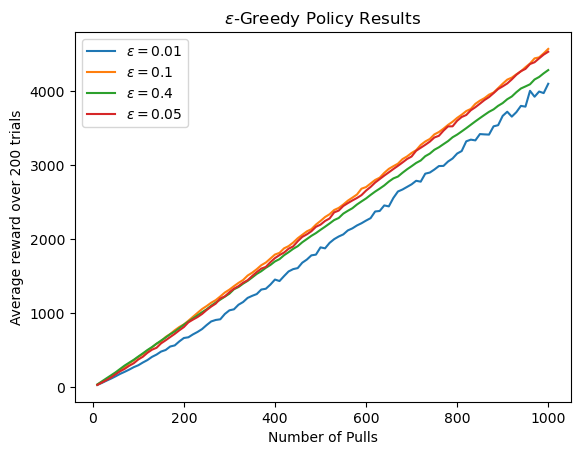

In [16]:
def plot_avg_trials(results):
    for key in results.keys():
        plt.plot(total_pulls, results[key])
        plt.legend(list(results.keys()))
        plt.xlabel("Number of Pulls")
        plt.ylabel("Average reward over {} trials".format(n_experiments))
        
plot_avg_trials(results)
plt.title("$\epsilon$-Greedy Policy Results")

We notice a few interesting things here:
* $\epsilon = 0.01$ isn't exploring enough and does the worst.  It is also the noisiest, because we explore so little that our data about which bandit is the best is unreliable
* $\epsilon = 0.4$ is exploring too much and not exploiting enough.  It's also the smoothest curve, because it explores so much that it has very reliable estimates on the best bandit, but it doesn't spend enough time exploiting that bandit
* $\epsilon = 0.1$ seems to perform the best, and it is in the middle with noise

So we want explore just enough but not too much.  What is the optimal $\epsilon$?  Well, it depends on the number of bandits and number of trials, but to get an idea for this specific example, we'll loop through a range of $\epsilon$ values and run a bunch of experiments for 1000 pulls where they start to diverge:

In [11]:
epsilons = np.linspace(0, 1, 101)
avg_rewards = np.zeros_like(epsilons)
for i, eps in enumerate(epsilons):
    reward = 0
    for j in range(n_experiments):
        reward_j, _ = epsilon_greedy(bandits, total_pulls=1000, eps=eps)
        reward += reward_j
    avg_rewards[i] = reward/n_experiments

0.05


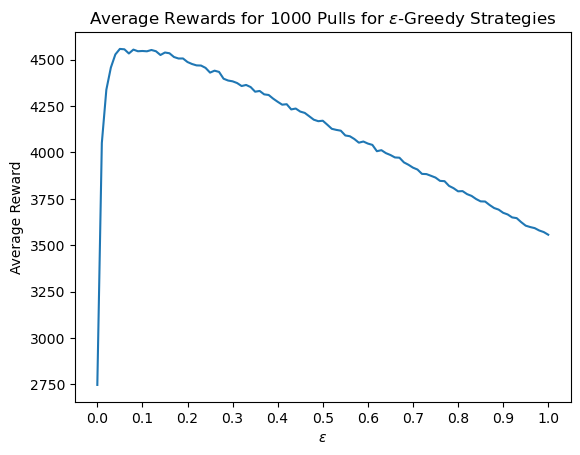

In [14]:
plt.plot(epsilons, avg_rewards)
plt.xlabel("$\epsilon$")
plt.ylabel("Average Reward")
plt.title("Average Rewards for 1000 Pulls for $\epsilon$-Greedy Strategies")
plt.xticks(np.linspace(0, 1, 11))
print(epsilons[np.argmax(avg_rewards)])

We weren't too far off with the 0.1 in this example...the optimum appears to be around 0.05, though it is about the same as 0.1 within noise.  Let's explore some other policy options to see if we can do better